# IT 496 : Introduction to Data Mining
## Lab : 2
### 16/10/2022

> Dhwanil Shah (201901450)

> Pathik Patel (202003002)

> Nisarg Suthar (202003030)

> Manjal Shah (202003037)

* Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras import layers

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [16,6]
plt.rcParams['font.size'] = 15

import warnings
warnings.filterwarnings('ignore')

* Uploading data to drive and mounting the drive to use it.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/IPL Ball-by-Ball 2008-2020 - IPL Ball-by-Ball 2008-2020.csv")
print(data.shape)
data.head()

(193468, 18)


,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193468 entries, 0 to 193467
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                193468 non-null  int64 
 1   inning            193468 non-null  int64 
 2   over              193468 non-null  int64 
 3   ball              193468 non-null  int64 
 4   batsman           193468 non-null  object
 5   non_striker       193468 non-null  object
 6   bowler            193468 non-null  object
 7   batsman_runs      193468 non-null  int64 
 8   extra_runs        193468 non-null  int64 
 9   total_runs        193468 non-null  int64 
 10  non_boundary      193468 non-null  int64 
 11  is_wicket         193468 non-null  int64 
 12  dismissal_kind    9495 non-null    object
 13  player_dismissed  9495 non-null    object
 14  fielder           6784 non-null    object
 15  extras_type       10233 non-null   object
 16  batting_team      193468 non-null  obj

In [ ]:
data.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

In [ ]:
len(data['id'].unique())

816

#### Found 2 games which did not have the second inning.

In [ ]:
set(data[data['inning']==1]['id'].unique()) - set(data[data['inning']==2]['id'].unique())

{501265, 829763}

#### Matches where bowling team was not recorded.

In [ ]:
data[data['bowling_team'].isnull()]['batting_team'].value_counts()

Royal Challengers Bangalore    128
Delhi Daredevils                63
Name: batting_team, dtype: int64

Bowlers of Pune Warriors

In [ ]:
data[(data['bowling_team'].isnull()) & (data['batting_team']=='Delhi Daredevils')]['bowler'].unique()

array(['AC Thomas', 'JP Faulkner', 'SS Mundhe', 'MR Marsh', 'R Sharma',
       'Yuvraj Singh'], dtype=object)

Bowlers of rajasthan Royals

In [ ]:
data[(data['bowling_team'].isnull()) & (data['batting_team']=='Royal Challengers Bangalore')]['bowler'].unique()

array(['TG Southee', 'DS Kulkarni', 'STR Binny', 'PV Tambe',
       'JP Faulkner', 'SR Watson'], dtype=object)

The teams 'Rising Pune Supergiants' and 'Rising Pune Supergiant' are the same.

In [ ]:
data[data['batting_team']=='Rising Pune Supergiants']['batsman'].unique()

array(['AM Rahane', 'F du Plessis', 'KP Pietersen', 'SPD Smith',
       'MS Dhoni', 'MR Marsh', 'R Bhatia', 'IK Pathan', 'R Ashwin',
       'NLTC Perera', 'M Ashwin', 'Ankit Sharma', 'JA Morkel',
       'SS Tiwary', 'PSP Handscomb', 'UT Khawaja', 'GJ Bailey', 'A Zampa'],
      dtype=object)

In [ ]:
data[data['batting_team']=='Rising Pune Supergiant']['batsman'].unique()

array(['AM Rahane', 'MA Agarwal', 'SPD Smith', 'BA Stokes', 'MS Dhoni',
       'MK Tiwary', 'DT Christian', 'AB Dinda', 'A Zampa', 'Imran Tahir',
       'F du Plessis', 'RA Tripathi', 'R Bhatia', 'DL Chahar',
       'LH Ferguson', 'RD Chahar', 'Ankit Sharma', 'SN Thakur',
       'JD Unadkat', 'Washington Sundar'], dtype=object)

## Finding the categorical and numerical attributes

In [ ]:
cat_features = [feature for feature in data.columns if data[feature].dtypes == 'O']
num_features = [feature for feature in data.columns if data[feature].dtypes != 'O']

Describing numerical attributes

In [ ]:
data[num_features].describe()

,id,inning,over,ball,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket
count,1.934680e+05,193468.000000,193468.000000,193468.000000,193468.000000,193468.000000,193468.000000,193468.000000,193468.000000
mean,7.567688e+05,1.482131,9.177027,3.615967,1.240231,0.066414,1.306645,0.000083,0.049078
std,3.060971e+05,0.499682,5.676848,1.807128,1.610867,0.339991,1.598802,0.009094,0.216031
min,3.359820e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.012270e+05,1.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.292970e+05,1.000000,9.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.082628e+06,2.000000,14.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.237181e+06,2.000000,19.000000,9.000000,6.000000,7.000000,7.000000,1.000000,1.000000


In [ ]:
data['is_wicket'].value_counts()

0    183973
1      9495
Name: is_wicket, dtype: int64

In [ ]:
data[cat_features].describe()

,batsman,non_striker,bowler,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
count,193468,193468,193468,9495,9495,6784,10233,193468,193277
unique,537,530,420,9,506,879,5,15,15
top,V Kohli,S Dhawan,Harbhajan Singh,caught,RG Sharma,MS Dhoni,wides,Mumbai Indians,Mumbai Indians
freq,4609,4593,3451,5743,167,164,5858,24466,24453


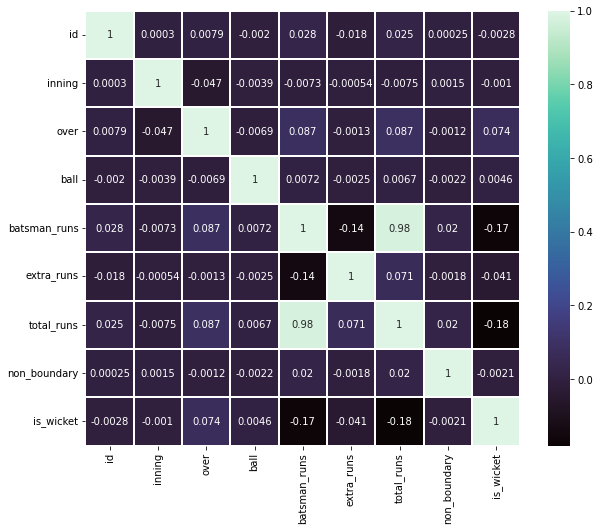

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, square=True, linewidths=1, cmap='mako')
plt.show()

### Distribuiton of Bowlers and Batsmen

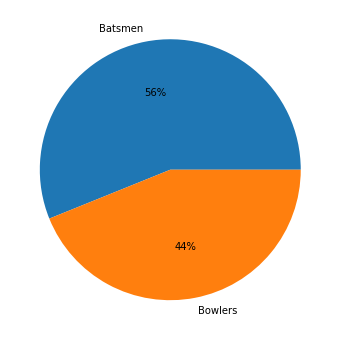

In [ ]:
plt.figure(figsize=(6,6))
labels = ['Batsmen', 'Bowlers']
plt.pie(list(map(len, [data['batsman'].unique(),data['bowler'].unique()])), labels = labels, autopct='%.0f%%')
plt.show()

### Batsman Stats

In [ ]:
batsman = defaultdict(lambda : 0)
batsman_fours = defaultdict(lambda : 0)
batsman_sixes = defaultdict(lambda : 0)

for i in data.index:
    batsman[data.loc[i,'batsman']] += data.loc[i,'batsman_runs']
    if data.loc[i,'batsman_runs'] == 4:
        batsman_fours[data.loc[i,'batsman']] += 1
    if data.loc[i,'batsman_runs'] == 6:
        batsman_sixes[data.loc[i,'batsman']] += 1

In [ ]:
batsman_runs = {k: v for k, v in sorted(batsman.items(), key=lambda item: item[1], reverse=True)}
batsman_fours = {k: v for k, v in sorted(batsman_fours.items(), key=lambda item: item[1], reverse=True)}
batsman_sixes = {k: v for k, v in sorted(batsman_sixes.items(), key=lambda item: item[1], reverse=True)}

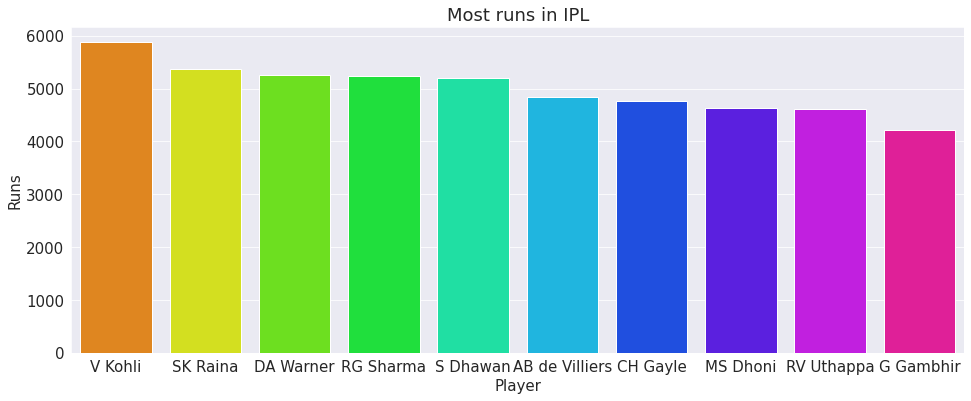

In [ ]:
sns.barplot(x = list(batsman_runs.keys())[:10], y = list(batsman_runs.values())[:10],palette='hsv')
plt.title('Most runs in IPL')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.show()

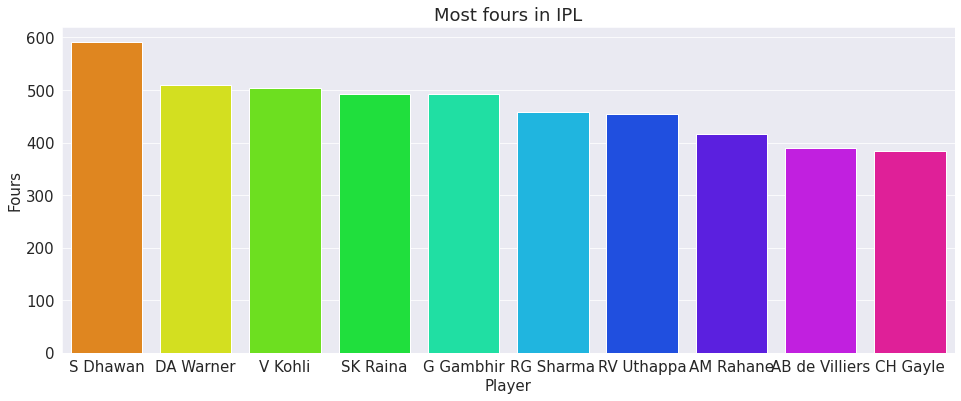

In [ ]:
sns.barplot(x = list(batsman_fours.keys())[:10], y = list(batsman_fours.values())[:10],palette='hsv')
plt.title('Most fours in IPL')
plt.xlabel('Player')
plt.ylabel('Fours')
plt.show()

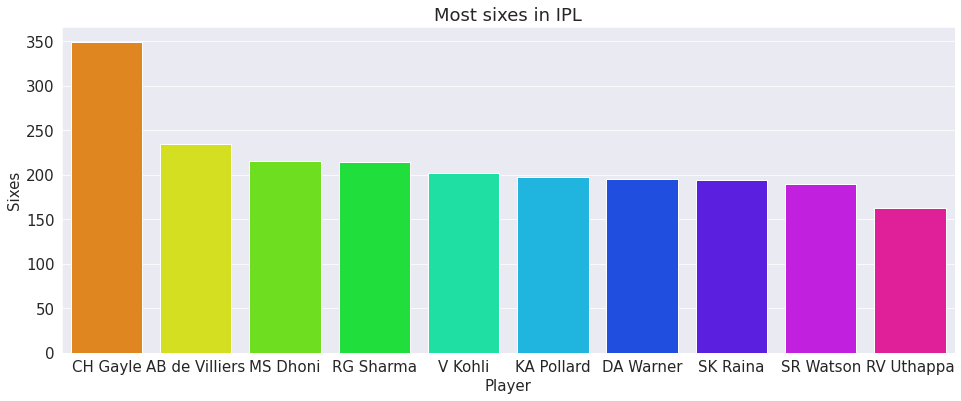

In [ ]:
sns.barplot(x = list(batsman_sixes.keys())[:10], y = list(batsman_sixes.values())[:10],palette='hsv')
plt.title('Most sixes in IPL')
plt.xlabel('Player')
plt.ylabel('Sixes')
plt.show()

### Bowler Stats

In [ ]:
most_wickets = defaultdict(lambda : 0)
most_extras = defaultdict(lambda : 0)
#batsman_sixes = defaultdict(lambda : 0)

for i in data.index:
    most_extras[data.loc[i,'bowler']] += data.loc[i,'extra_runs']
    if data.loc[i,'is_wicket'] == 1 and data.loc[i,'dismissal_kind'] not in ['run out', 'retired hurt', 'obstructing the field']:
        most_wickets[data.loc[i,'bowler']] += 1

In [ ]:
most_wickets = {k: v for k, v in sorted(most_wickets.items(), key=lambda item: item[1], reverse=True)}
most_extras = {k: v for k, v in sorted(most_extras.items(), key=lambda item: item[1], reverse=True)}
#batsman_sixes = {k: v for k, v in sorted(batsman_sixes.items(), key=lambda item: item[1], reverse=True)}

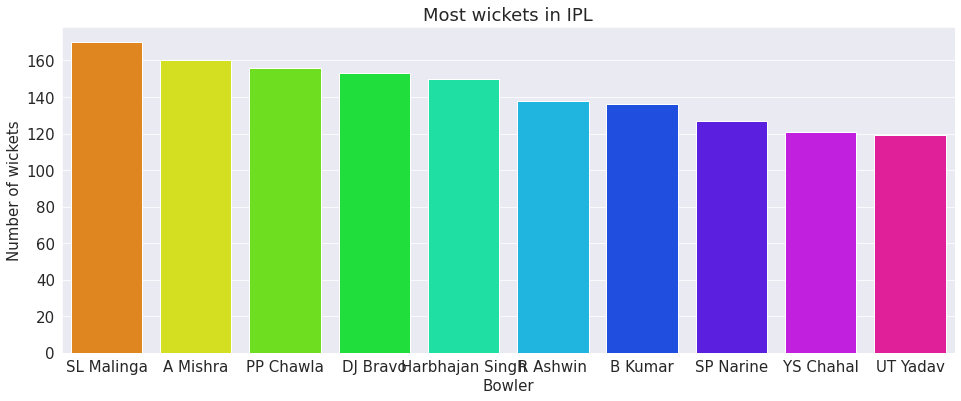

In [ ]:
sns.barplot(x = list(most_wickets.keys())[:10], y = list(most_wickets.values())[:10],palette='hsv')
plt.title('Most wickets in IPL')
plt.xlabel('Bowler')
plt.ylabel('Number of wickets')
plt.show()

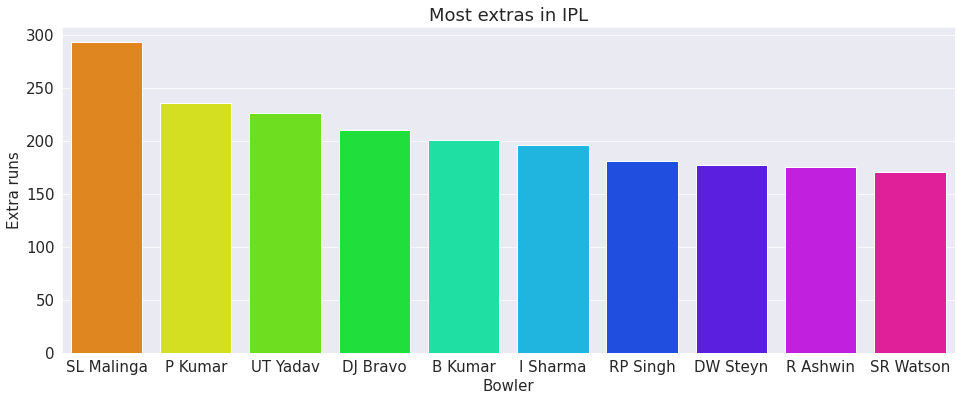

In [ ]:
sns.barplot(x = list(most_extras.keys())[:10], y = list(most_extras.values())[:10],palette='hsv')
plt.title('Most extras in IPL')
plt.xlabel('Bowler')
plt.ylabel('Extra runs')
plt.show()

### Fielding Stats

In [ ]:
data['dismissal_kind'].value_counts()

caught                   5743
bowled                   1700
run out                   893
lbw                       571
stumped                   294
caught and bowled         269
hit wicket                 12
retired hurt               11
obstructing the field       2
Name: dismissal_kind, dtype: int64

In [ ]:
most_catches = defaultdict(lambda : 0)
most_runouts = defaultdict(lambda : 0)
most_stumped = defaultdict(lambda : 0)
most_CandB = defaultdict(lambda : 0)

for i in data.index:
    if data.loc[i,'dismissal_kind'] == 'caught':
        most_catches[data.loc[i,'fielder']] += 1
    if data.loc[i,'dismissal_kind'] == 'run out' and str(data.loc[i,'fielder']) != 'nan':
        most_runouts[data.loc[i,'fielder'].split(',')[0]] += 1
    if data.loc[i,'dismissal_kind'] == 'stumped':
        most_stumped[data.loc[i,'fielder']] += 1
    if data.loc[i,'dismissal_kind'] == 'caught and bowled':
        most_CandB[data.loc[i,'bowler']] += 1

In [ ]:
most_catches = {k: v for k, v in sorted(most_catches.items(), key=lambda item: item[1], reverse=True)}
most_runouts = {k: v for k, v in sorted(most_runouts.items(), key=lambda item: item[1], reverse=True)}
most_stumped = {k: v for k, v in sorted(most_stumped.items(), key=lambda item: item[1], reverse=True)}
most_CandB = {k: v for k, v in sorted(most_CandB.items(), key=lambda item: item[1], reverse=True)}

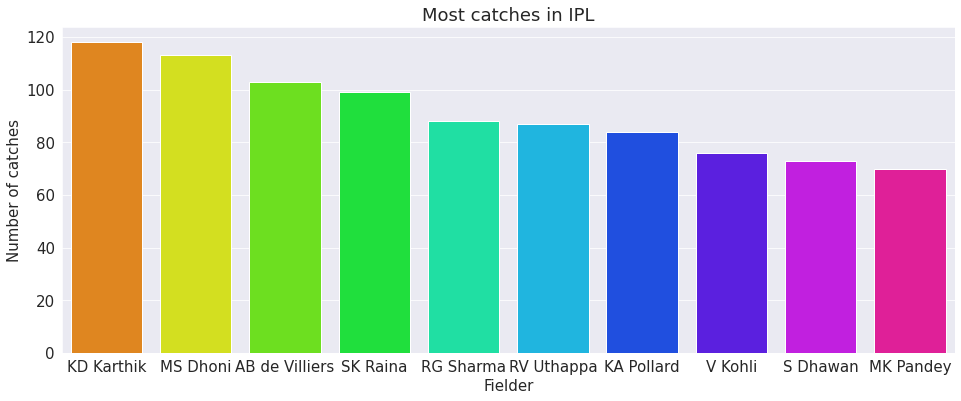

In [ ]:
sns.barplot(x = list(most_catches.keys())[:10], y = list(most_catches.values())[:10],palette='hsv')
plt.title('Most catches in IPL')
plt.xlabel('Fielder')
plt.ylabel('Number of catches')
plt.show()

**The top 3 fielders in this list are wicket keepers which should have been the case since many of catches are edged and gone to the keeper**

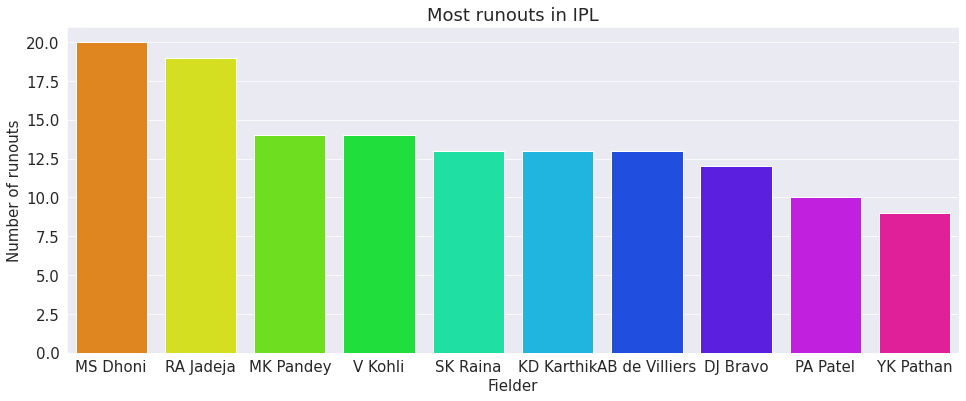

In [ ]:
sns.barplot(x = list(most_runouts.keys())[:10], y = list(most_runouts.values())[:10],palette='hsv')
plt.title('Most runouts in IPL')
plt.xlabel('Fielder')
plt.ylabel('Number of runouts')
plt.show()

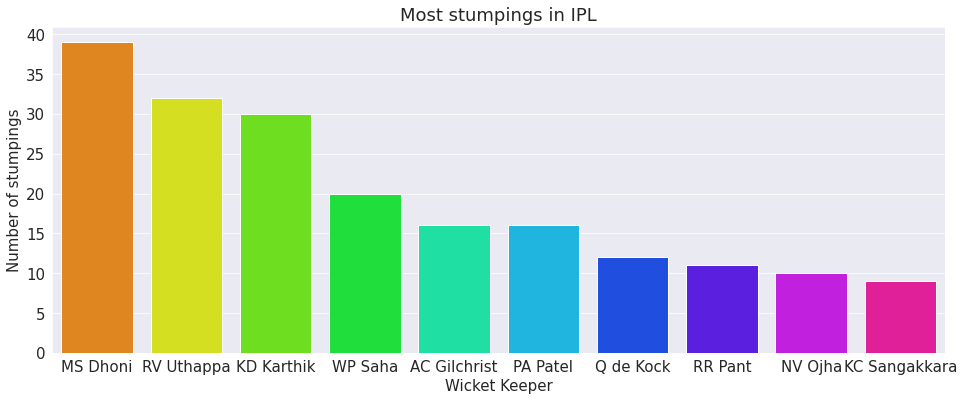

In [ ]:
sns.barplot(x = list(most_stumped.keys())[:10], y = list(most_stumped.values())[:10],palette='hsv')
plt.title('Most stumpings in IPL')
plt.xlabel('Wicket Keeper')
plt.ylabel('Number of stumpings')
plt.show()

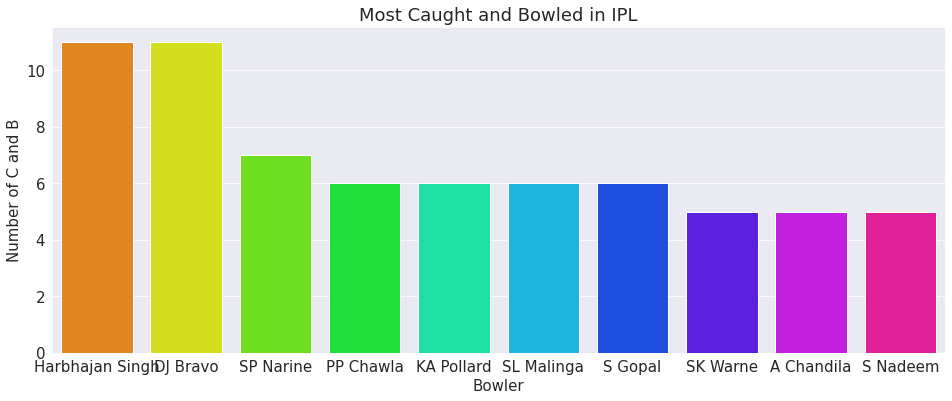

In [ ]:
sns.barplot(x = list(most_CandB.keys())[:10], y = list(most_CandB.values())[:10],palette='hsv')
plt.title('Most Caught and Bowled in IPL')
plt.xlabel('Bowler')
plt.ylabel('Number of C and B')
plt.show()

## Data Preprocessing

In [ ]:
def data_preprocessing(data):
    
    for i in data.index:
        if(str(data['bowling_team'][i])=='nan' and data['batting_team'][i]=='Delhi Daredevils'):
            data['bowling_team'][i] = 'Pune Warriors'
        elif(str(data['bowling_team'][i])=='nan' and data['batting_team'][i]=='Royal Challengers Bangalore'):
            data['bowling_team'][i] = 'Rajasthan Royals'
    
    data['batting_team'].replace('Rising Pune Supergiants', 'Rising Pune Supergiant', inplace=True)
    data['bowling_team'].replace('Rising Pune Supergiants', 'Rising Pune Supergiant', inplace=True)
    
    new_dat = data[["id","over","inning","total_runs","is_wicket","batting_team","bowling_team"]]
    new_dat = new_dat.drop(new_dat[(new_dat.id == 501265) | (new_dat.id == 829763)].index)

    new_dat["r_till_10"] = new_dat["total_runs"]
    new_dat["w_till_10"] = new_dat["is_wicket"]
    
    over = 10
    new_dat["r_till_10"].where((new_dat["over"] <= over),0,inplace = True)
    new_dat["w_till_10"].where((new_dat["over"] <= over),0,inplace = True)
    
    new_dat = new_dat.groupby(["id","inning","batting_team","bowling_team"],as_index=False)["total_runs","r_till_10","w_till_10"].sum()
    
    tilo = pd.DataFrame()
    ids = new_dat["id"].unique()

    for id in ids:
      t = new_dat[new_dat["id"]==id]
      try:
        fin = t.iloc[0,:]
        sin = t.iloc[1,:]
      except:
        print(t)
      if(fin[4] > sin[4]):
       # tilo = tilo.append({'Team':fin[2],"opponent" : fin[3],"r_till_10" : fin[5],"w_till_10" : fin[6],'bat/bowl':"first_to_bat","win/loss":"win"}, ignore_index=True)
        tilo = tilo.append({'Team':sin[2],"opponent" : sin[3],"r_till_10" : fin[4]-sin[5],"w_till_10" : sin[6],"r_run_rate":(fin[4]-sin[5])/(20-over),"c_run_rate":(sin[5]/over),"win/loss":"loss"}, ignore_index=True)
      else:
      #  tilo = tilo.append({'Team':fin[2],"opponent" : fin[3],"r_till_10" : fin[5],"w_till_10" : fin[6],'bat/bowl':"first_to_bat","win/loss":"loss"}, ignore_index=True)
        tilo = tilo.append({'Team':sin[2],"opponent" : sin[3],"r_till_10" : fin[4]-sin[5],"w_till_10" : sin[6],"r_run_rate":(fin[4]-sin[5])/(20-over),"c_run_rate":(sin[5]/over),"win/loss":"win"}, ignore_index=True)
        
    tilo = pd.get_dummies(tilo,columns = ['Team','opponent'])
    return tilo

In [ ]:
cleaned_data = data_preprocessing(data)
X = cleaned_data.drop('win/loss',axis=1)
y = cleaned_data['win/loss']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)  

## Models with hyperparameter tuning

### Random Search

#### Logistic regression

In [ ]:
fin_pipe =  Pipeline(steps=(["scalling",StandardScaler()],["classifier",LogisticRegression()]))
classifier_param_grid = { 
                         "classifier__penalty" : ['l1', 'l2', 'elasticnet'],
                         "classifier__dual":[True, False],
                         "classifier__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'],
                         "classifier__penalty":['l2'],
                         "classifier__C":[10, 1.0, 0.1, 0.01, 0.001]    
                        }
Randomcv = RandomizedSearchCV(estimator=fin_pipe,param_distributions=classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Randomcv.fit(X_train,y_train)
print(f"BEST SCORE: {Randomcv.best_score_}")
final_classifier_1 = Randomcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7757369348209042
VALIDATION_SCORE: 0.8404907975460123


BEST CLASSIFIER: Pipeline(steps=[('scalling', StandardScaler()),
                ['classifier',
                 LogisticRegression(C=0.001, solver='liblinear')]])


#### KNN

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",KNeighborsClassifier()]))
classifier_param_grid = {
                         'classifier__n_neighbors' : range(5,30,1),
                         'classifier__weights' : ['uniform','distance'],
                         'classifier__metric' : ['minkowski','euclidean','manhattan'],
                         'classifier__algorithm' : ['ball_tree', 'kd_tree', 'brute']
                        }
Randomcv = RandomizedSearchCV(fin_pipe,classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Randomcv.fit(X_train,y_train)
print(f"BEST SCORE: {Randomcv.best_score_}")
final_classifier_1 = Randomcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7603405754550793
VALIDATION_SCORE: 0.7914110429447853


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier',
                 KNeighborsClassifier(algorithm='brute', metric='manhattan',
                                      n_neighbors=25)]])


#### SVC

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",SVC()]))
params = {
        'classifier__C': [0.1, 1, 10, 100, 1000],
        'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid', 'precomputed'],
        'classifier__degree' : [1,2,3,4],
        'classifier__shrinking' : [True, False]
         }
Randomcv = RandomizedSearchCV(fin_pipe,params,scoring="accuracy",cv=5)

In [ ]:
Randomcv.fit(X_train,y_train)
print(f"BEST SCORE: {Randomcv.best_score_}")
final_classifier_1 = Randomcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.76190252495596
VALIDATION_SCORE: 0.8220858895705522


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier', SVC(C=100, gamma=0.001)]])


#### Decision Tree

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",DecisionTreeClassifier(random_state=11)]))
classifier_param_grid = {
                        "classifier__criterion":["gini","entropy"],
                        "classifier__max_depth":np.arange(1,21,2),
                        "classifier__min_samples_split":np.arange(11,31,3),
                        "classifier__min_samples_leaf":np.arange(1,10,2)
                        }
Randomcv = RandomizedSearchCV(fin_pipe,classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Randomcv.fit(X_train,y_train)
print(f"BEST SCORE: {Randomcv.best_score_}")
final_classifier_1 = Randomcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7588490898414563
VALIDATION_SCORE: 0.8098159509202454


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=1,
                                        min_samples_split=26,
                                        random_state=11)]])


#### Random forest

In [ ]:
fin_pipe =  Pipeline(steps=(["scalling",StandardScaler()],["classifier",RandomForestClassifier(random_state=11)]))
classifier_param_grid = {
                        "classifier__criterion":["gini","entropy"],
                        "classifier__n_estimators":np.arange(50,1200,500),
                        "classifier__min_samples_split":np.arange(2,21,3),
                        "classifier__min_samples_leaf":np.arange(1,10,2)
                        }
Randomcv = RandomizedSearchCV(estimator=fin_pipe,param_distributions=classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Randomcv.fit(X_train,y_train)
print(f"BEST SCORE: {Randomcv.best_score_}")
final_classifier_1 = Randomcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7726482677627715
VALIDATION_SCORE: 0.8343558282208589


BEST CLASSIFIER: Pipeline(steps=[('scalling', StandardScaler()),
                ['classifier',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=5,
                                        min_samples_split=8, n_estimators=50,
                                        random_state=11)]])


### Grid Search

#### Logistic regression

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",LogisticRegression()]))
classifier_param_grid = { 
                         "classifier__penalty" : ['l1', 'l2', 'elasticnet'],
                         "classifier__dual":[True, False],
                         "classifier__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'],
                         "classifier__C":[10, 1.0, 0.1, 0.01, 0.001]    
                        }
Gridcv = GridSearchCV(estimator=fin_pipe,param_grid=classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Gridcv.fit(X_train,y_train)
print(f"BEST SCORE: {Gridcv.best_score_}")
final_classifier_1 = Gridcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7803405754550792
VALIDATION_SCORE: 0.8159509202453987


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear')]])


#### KNN

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",KNeighborsClassifier()]))
params = {
          'classifier__n_neighbors' : range(5,30,5),
          'classifier__weights' : ['uniform','distance'],
          'classifier__metric' : ['minkowski','euclidean','manhattan'],
          'classifier__algorithm' : ['ball_tree', 'kd_tree', 'brute']
         }
Gridcv = GridSearchCV(fin_pipe,params,scoring="accuracy",cv=5)

In [ ]:
Gridcv.fit(X_train,y_train)
print(f"BEST SCORE: {Gridcv.best_score_}")
final_classifier_1 = Gridcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7603405754550793
VALIDATION_SCORE: 0.7914110429447853


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      n_neighbors=25)]])


#### SVC

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",SVC()]))
params = {
          'classifier__C': [100, 1000],
          'classifier__gamma': [0.001, 0.0001],
          'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
          'classifier__degree' : [2,3,4],
         }
Gridcv = GridSearchCV(fin_pipe,params,scoring="accuracy", n_jobs= -1, cv=3)

In [ ]:
Gridcv.fit(X_train,y_train)
print(f"BEST SCORE: {Gridcv.best_score_}")
final_classifier_1 = Gridcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7603686635944701
VALIDATION_SCORE: 0.8343558282208589


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier', SVC(C=100, degree=2, gamma=0.0001)]])


#### Decision Tree

In [ ]:
fin_pipe =  Pipeline(steps=(["scaling",StandardScaler()],["classifier",DecisionTreeClassifier(random_state=11)]))
classifier_param_grid = {
                        "classifier__criterion":["gini","entropy"],
                        "classifier__max_depth":np.arange(1,21,5),
                        "classifier__min_samples_split":np.arange(10,31,5),
                        "classifier__min_samples_leaf":np.arange(1,10,4)
                        }
Gridcv = GridSearchCV(fin_pipe,classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Gridcv.fit(X_train,y_train)
print(f"BEST SCORE: {Gridcv.best_score_}")
final_classifier_1 = Gridcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.7588490898414563
VALIDATION_SCORE: 0.8098159509202454


BEST CLASSIFIER: Pipeline(steps=[('scaling', StandardScaler()),
                ['classifier',
                 DecisionTreeClassifier(max_depth=1, min_samples_split=10,
                                        random_state=11)]])


#### Random forest

In [ ]:
fin_pipe =  Pipeline(steps=(["scalling",StandardScaler()],["classifier",RandomForestClassifier(random_state=11)]))
classifier_param_grid = { 
                        "classifier__criterion":["gini","entropy"],
                        "classifier__n_estimators":np.arange(200,1000,200),
                        "classifier__min_samples_split":np.arange(10,21,3),
                        "classifier__min_samples_leaf":np.arange(1,10,3)
                        }
Gridcv = GridSearchCV(estimator=fin_pipe,param_grid=classifier_param_grid,scoring="accuracy",cv=5)

In [ ]:
Gridcv.fit(X_train,y_train)
print(f"BEST SCORE: {Gridcv.best_score_}")
final_classifier_1 = Gridcv.best_estimator_
print(f"VALIDATION_SCORE: {final_classifier_1.score(X_test,y_test)}")
print(f"\n\nBEST CLASSIFIER: {final_classifier_1}")

BEST SCORE: 0.775713446858485
VALIDATION_SCORE: 0.8282208588957055


BEST CLASSIFIER: Pipeline(steps=[('scalling', StandardScaler()),
                ['classifier',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=11)]])


### Manual Search

#### ANN

In [ ]:
y_train = y_train.map(lambda x:1 if x=='win' else 0)
y_test = y_test.map(lambda x:1 if x=='win' else 0)

Epoch 1/200
6/6 [==============================] - 1s 52ms/step - loss: 0.6633 - binary_accuracy: 0.6114 - val_loss: 1.4793 - val_binary_accuracy: 0.5031
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 0.6400 - binary_accuracy: 0.6359 - val_loss: 1.0012 - val_binary_accuracy: 0.5706
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 0.6215 - binary_accuracy: 0.6482 - val_loss: 0.7651 - val_binary_accuracy: 0.6135
Epoch 4/200
6/6 [==============================] - 0s 13ms/step - loss: 0.6105 - binary_accuracy: 0.6682 - val_loss: 0.6576 - val_binary_accuracy: 0.6503
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 0.5984 - binary_accuracy: 0.6774 - val_loss: 0.5995 - val_binary_accuracy: 0.6748
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 0.5890 - binary_accuracy: 0.6790 - val_loss: 0.5717 - val_binary_accuracy: 0.6810
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 0.5727 -

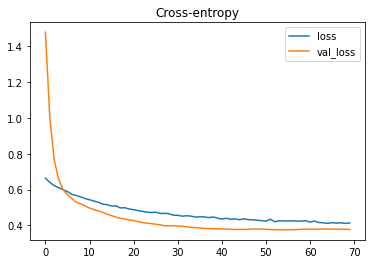

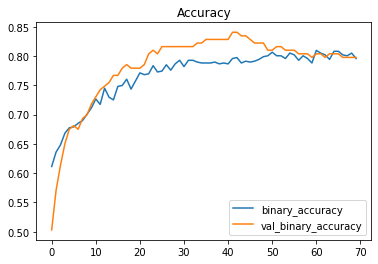

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    layers.Dense(16, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    # layers.Dense(6, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
ann = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=200,
    callbacks=[early_stopping],
)
history_df = pd.DataFrame(ann.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [ ]:
history_df.describe()

,loss,binary_accuracy,val_loss,val_binary_accuracy
count,70.000000,70.000000,70.000000,70.000000
mean,0.471897,0.767435,0.443628,0.782472
std,0.062196,0.046213,0.160921,0.064214
min,0.410387,0.611367,0.374115,0.503067
25%,0.425455,0.751536,0.377936,0.779141
50%,0.447206,0.788018,0.385768,0.803681
75%,0.498027,0.795699,0.438107,0.815951
max,0.663278,0.809524,1.479267,0.840491


---

---